In [24]:
import numpy as np
from astropy.io import fits
import astropy.units as u
import astropy.coordinates as coord
import matplotlib.pyplot as plt
import mceh
import random
import tqdm
from astropy import table

In [5]:
efeds, hsc, rd = mceh.init('efeds', 'hsc', 'rd')

In [6]:
hsc.colnames

['object_id',
 'tract',
 'ra',
 'dec',
 'gmag_cmodel',
 'rmag_cmodel',
 'imag_cmodel',
 'zmag_cmodel',
 'ymag_cmodel',
 'gmag_err',
 'rmag_err',
 'imag_err',
 'zmag_err',
 'ymag_err',
 'photoz_mean',
 'photoz_mode',
 'photoz_median',
 'photoz_best',
 'photoz_mc',
 'photoz_err68_min',
 'photoz_err68_max',
 'photoz_err95_min',
 'photoz_err95_max']

In [7]:
ra_width = max(hsc['ra'].value) - min(hsc['ra'].value)
min(hsc['ra'].value), max(hsc['ra'].value)

(127.80994023048872, 153.49999636210816)

In [8]:
min(rd['RA'].value), max(rd['RA'].value)

(127.81019382633114, 153.49999621241412)

In [9]:
dec_width = max(hsc['dec'].value) - min(hsc['dec'].value)
min(hsc['dec'].value), max(hsc['dec'].value)

(-2.023433194900005, 5.047695845391878)

In [10]:
min(rd['RA'].value), max(rd['RA'].value)

(127.81019382633114, 153.49999621241412)

In [11]:
360 / 15 * 5

120.0

In [12]:
low_ra, high_ra = min(hsc['ra'].value) * u.deg, max(hsc['ra'].value) * u.deg
low_dec, high_dec = min(hsc['dec'].value) * u.deg, max(hsc['dec'].value) * u.deg

In [13]:
low_arcsin_dec, high_arcsin_dec = np.arcsin(low_dec.to(u.rad).value), np.arcsin(high_dec.to(u.rad).value)

In [14]:
low_ra

<Quantity 127.80994023 deg>

In [15]:
np.random.uniform(low = low_ra.value, high=high_dec.value, size=10)

array([ 29.65920461,  84.9180665 ,  66.34988509, 103.05966938,
        89.95025652,  89.35652299,  11.28661114,  80.64482264,
        35.64399685,  65.75375762])

In [16]:
def calculate_area(ra_min, ra_max, dec_min, dec_max):
    return (((ra_max.to(u.rad).value - ra_min.to(u.rad).value) 
            * (np.sin(dec_max.to(u.rad).value) - np.sin(dec_min.to(u.rad).value)
               )) * u.rad**2).to(u.deg**2)

In [17]:
efeds_num = len(efeds)

In [18]:
a = coord.SkyCoord([1, 2] * u.deg, u.deg * [3, 4])
b = coord.SkyCoord(u.deg * [1, 2], u.deg * [10, 4])

In [19]:
(a.separation(b))[1]

<Angle 0. deg>

In [20]:
import copy
new_efeds = copy.deepcopy(efeds)
print(len(new_efeds))
new_efeds.remove_rows([0, 1])
new_efeds[0]

542


Name,ID_SRC,RA_CORR,DEC_CORR,Z_BEST_COMB,low_cont_flag,median_500c_lcdm,r500c_lcdm,area,unmasked_area,i_cmag,g_cmag,r_cmag,z_cmag,y_cmag,galaxy_index,unmasked_fraction,SIGMA_Z_BEST_COMB
,,deg,deg,,,solMass / littleh,arcmin,arcmin2,arcmin2,,,,,,,,
bytes22,int32,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64
eFEDS J093521.0+023234,82,143.83740358134753,2.542871690824143,0.50982,True,14.625807820724724,2.908020037930207,26.567129720257167,19.54,20.530053289565636,22.887668350894003,21.420511980895945,20.17115744085418,20.015064747400526,[ 94653 94654 102047 ... 23753178 23760481 23760529],0.7354953359941231,0.005174685772215613


In [21]:
# Remove the cluster parts from hsc
import mceh.find_luminosity as fl
import copy

clean_hsc = copy.deepcopy(hsc)
clean_rd = copy.deepcopy(rd)

for i in tqdm.tqdm(range(len(efeds))):
    this_efeds = efeds[i]
    hsc_in_index = fl.index_within_angular_radius(clean_hsc['ra'], 
                                                  clean_hsc['dec'], 
                                                  this_efeds['RA_CORR'], 
                                                  this_efeds['DEC_CORR'], 
                                                  this_efeds['r500c_lcdm'])
    rd_in_index = fl.index_within_angular_radius(clean_rd['RA'], 
                                                 clean_rd['DEC'], 
                                                 this_efeds['RA_CORR'], 
                                                 this_efeds['DEC_CORR'], 
                                                 this_efeds['r500c_lcdm'])
    clean_hsc.remove_rows(hsc_in_index)
    clean_rd.remove_rows(rd_in_index)



100%|██████████| 542/542 [10:07<00:00,  1.12s/it]


In [22]:
print(len(hsc), len(clean_hsc))

24720393 24164183


In [ ]:
hsc_density = len(clean_hsc) / (len(clean_rd) / 100 * u.arcmin**2)
hsc_num = int((hsc_density * calculate_area(low_ra, high_ra, low_dec, high_dec)
               ).to(u.dimensionless_unscaled).value) # Number of fake galaxies
np.random.seed(seed=20250112)
fake_hsc = table.QTable()
fake_hsc_ra = np.random.uniform(low = low_ra.value, high=high_ra.value, 
                                size=hsc_num) * u.deg
fake_hsc['ra'] = fake_hsc_ra
fake_hsc_dec = (np.arcsin(np.random.uniform(low=low_dec.to(u.rad).value, 
                                            high=high_dec.to(u.rad).value, 
                                            size=hsc_num)) 
          * u.rad).to(u.deg)
fake_hsc['dec'] = fake_hsc_dec
correspond_index = np.random.randint(len(clean_hsc), size=hsc_num)
fake_hsc['correspond_index'] = correspond_index
fake_hsc['object_id'] = hsc['object_id'][correspond_index]
mag_cmodel = [clean_hsc['gmag_cmodel'], 
              clean_hsc['rmag_cmodel'], 
              clean_hsc['imag_cmodel'],
              clean_hsc['zmag_cmodel'], 
              clean_hsc['ymag_cmodel']]
mag_err = [clean_hsc['gmag_err'], 
           clean_hsc['rmag_err'], 
           clean_hsc['imag_err'], 
           clean_hsc['zmag_err'],
           clean_hsc['ymag_err']]
# zmag has no masked?
fake_mag_cmodel = []
for b in range(5):
    this_mag = mag_cmodel[b][correspond_index]
    this_err = mag_err[b][correspond_index]
    fake_mag_cmodel.append(np.ma.masked_invalid(np.random.normal(this_mag, 
                                                                 this_err)))
    fake_mag_cmodel[b].fill_value = np.nan

'\nfor i in tqdm.tqdm(range(hsc_num)):\n    for j in range(5):\n        cen_value = mag_cmodel[j][correspond_index[i]]\n        err_value = mag_err[j][correspond_index[i]]\n        is_masked = mag_ismasked[j][correspond_index[i]]\n        if is_masked:\n            fake_mag_cmodel[j] = np.ma.append(fake_mag_cmodel[j], \n                                              cen_value\n                                              )\n        else:\n            value = np.random.normal(cen_value, err_value)\n            if np.isnan(value):\n                print(correspond_index[i], j)\n            fake_mag_cmodel[j] = np.ma.append(fake_mag_cmodel[j], \n                                              np.random.normal(cen_value,\n                                                               err_value)\n                                              )\nfor mag_array in fake_mag_cmodel:\n    mag_array.fill_value = np.nan\n'

In [224]:
original_hist = np.histogram(mag_cmodel[0], mceh.bins2)
fake_hist = np.histogram(fake_mag_cmodel[0], mceh.bins2)

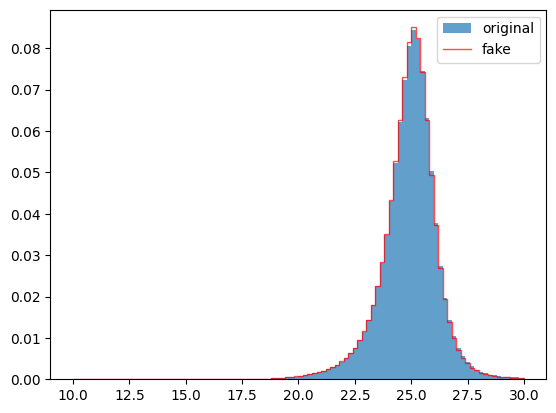

In [ ]:
plt.stairs(original_hist[0] / len(clean_hsc), original_hist[1], label='original', alpha=0.7, fill=True)
plt.stairs(fake_hist[0] / hsc_num, fake_hist[1], label='fake', alpha=0.7, color='red')
plt.legend()

In [227]:
mag_name = ['gmag_cmodel', 'rmag_cmodel', 'imag_cmodel', 'zmag_cmodel', 'ymag_cmodel']
for i in range(5):
    fake_hsc[mag_name[i]] = fake_mag_cmodel[i]

In [228]:
fake_hsc.colnames

['ra',
 'dec',
 'correspond_index',
 'object_id',
 'gmag_cmodel',
 'rmag_cmodel',
 'imag_cmodel',
 'zmag_cmodel',
 'ymag_cmodel']

In [229]:
fake_hsc.write('data/fake_hsc_only_bkg.fits')